In [114]:
import os
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

In [115]:
#하이퍼 파라미터 튜닝

CFG = {
    'IMG_SIZE':128, #이미지 사이즈
    'EPOCHS':50, #에포크
    'LEARNING_RATE':2e-2, #학습률
    'BATCH_SIZE':12, #배치사이즈
    'SEED':41, #시드
}

In [116]:
# Seed 고정
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [117]:
import pandas as pd
label_df = pd.read_csv('user_data/train.csv')
label_df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


In [118]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


# 전처리

In [119]:
label_df['label'][label_df['label'] == '10-1'] = 10 ## label : 10-1 -> 10
label_df['label'][label_df['label'] == '10-2'] = 0 ## Label : 10-2 -> 0
label_df['label'] = label_df['label'].apply(lambda x : int(x)) ## Dtype : object -> int

In [120]:
label_df.head()

,file_name,label
0,001.png,0
1,002.png,10
2,003.png,3
3,004.png,8
4,005.png,9


In [125]:
from glob import glob
import re
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend([re.sub('\\\\','/',i) for i in glob(os.path.join(data_dir, '*.png'))])
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(label_df['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend([re.sub('\\\\','/',i) for i in glob(os.path.join(data_dir, '*.png'))])
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    
    return img_path_list

In [126]:
all_img_path, all_label = get_train_data('user_data/train')
test_img_path = get_test_data('user_data/test')

# CustomDataset

In [128]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

# Train / Validation Split

In [129]:
# Train : Validation = 0.8 : 0.25 Split
train_len = int(len(all_img_path)*0.75)
Vali_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [130]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', Vali_len)

train set 길이 :  643
vaildation set 길이 :  214


In [131]:
train_transform = transforms.Compose([
                    transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), #이미지 사이즈 변형
                    transforms.ToTensor(), #이미지 데이터를 tensor
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #이미지 정규화
                    
                    ])

test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

# Dataloader

In [132]:
# Get Dataloader

#CustomDataset class를 통하여 train dataset생성
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 
#만든 train dataset를 DataLoader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) #BATCH_SIZE : 24

#vaildation 에서도 적용
vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [133]:
train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',Vali_len, '/ total valid batches :', vali_batches)

total train imgs : 643 / total train batches : 54
total valid imgs : 214 / total valid batches : 18


# 이미지 및 shape 확인

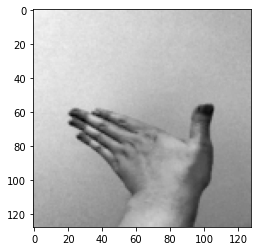

Label: 9


In [134]:
import cv2
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader)) #iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
                                                        #next는 이터레이터에서 값을 차례대로 꺼냅니다. 
img = train_features[0]
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

In [135]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Batch Labels shape: {train_labels}")

Feature batch shape: torch.Size([12, 3, 128, 128])
Batch Labels shape: tensor([9, 1, 9, 8, 1, 2, 6, 1, 4, 0, 0, 7])


In [136]:
from tqdm.auto import tqdm
import torch.nn as nn # 신경망들이 포함됨
#import torch.nn.init as init # 텐서에 초기값을 줌

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.fc_layer = nn.Sequential( 
            nn.Linear(3136, 11) #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x) #1층
        
        x = self.layer2(x) #2층
         
        x = self.layer3(x) #3층
        
        x = self.layer4(x) #4층
        
        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열
        
        out = self.fc_layer(x)
        return out

# 모델 학습

In [137]:
import torch.optim as optim # 최적화 알고리즘들이 포함힘

model = CNNclassification().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

In [138]:
def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    
    #Loss Function 정의
    criterion = nn.CrossEntropyLoss().to(device)
    best_acc = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1): #에포크 설정
        model.train() #모델 학습
        running_loss = 0.0
            
        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device) #배치 데이터
            optimizer.zero_grad() #배치마다 optimizer 초기화
        
            # Data -> Model -> Output
            logit = model(img) #예측값 산출
            loss = criterion(logit, label) #손실함수 계산
            
            # 역전파
            loss.backward() #손실함수 기준 역전파 
            optimizer.step() #가중치 최적화
            running_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
        #Validation set 평가
        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        vali_loss = 0.0
        correct = 0
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for img, label in tqdm(iter(vali_loader)):
                img, label = img.to(device), label.to(device)

                logit = model(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
                correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
        vali_acc = 100 * correct / len(vali_loader.dataset)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))
        
        #베스트 모델 저장
        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), './saved/best_model.pth') #이 디렉토리에 best_model.pth을 저장
            print('Model Saved.')

In [139]:
train(model, optimizer, train_loader, scheduler, device)

  0%|          | 0/54 [00:00<?, ?it/s]

[1] Train loss: 2.3991788979


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3981, Accuracy: 15/215 ( 7%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[2] Train loss: 2.3943916338


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4001, Accuracy: 21/215 ( 10%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[3] Train loss: 2.3911464568


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4018, Accuracy: 23/215 ( 11%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[4] Train loss: 2.3896839707


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4002, Accuracy: 28/215 ( 13%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[5] Train loss: 2.3840780965


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4000, Accuracy: 25/215 ( 12%)



  0%|          | 0/54 [00:00<?, ?it/s]

[6] Train loss: 2.3789581060


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3929, Accuracy: 22/215 ( 10%)



  0%|          | 0/54 [00:00<?, ?it/s]

[7] Train loss: 2.3681286441


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3833, Accuracy: 22/215 ( 10%)



  0%|          | 0/54 [00:00<?, ?it/s]

[8] Train loss: 2.3421142101


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3659, Accuracy: 28/215 ( 13%)



  0%|          | 0/54 [00:00<?, ?it/s]

[9] Train loss: 2.3052343395


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2898, Accuracy: 40/215 ( 19%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[10] Train loss: 2.1991597524


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2205, Accuracy: 39/215 ( 18%)



  0%|          | 0/54 [00:00<?, ?it/s]

[11] Train loss: 1.9977584945


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1598, Accuracy: 50/215 ( 23%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[12] Train loss: 1.7076525225


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.0008, Accuracy: 63/215 ( 29%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[13] Train loss: 1.4107039825


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.7716, Accuracy: 82/215 ( 38%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[14] Train loss: 1.1618980423


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.9054, Accuracy: 93/215 ( 43%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[15] Train loss: 0.9693765971


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.9967, Accuracy: 95/215 ( 44%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[16] Train loss: 0.7692399988


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.6995, Accuracy: 118/215 ( 55%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[17] Train loss: 0.6346029011


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.6354, Accuracy: 119/215 ( 55%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[18] Train loss: 0.4598490565


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1977, Accuracy: 103/215 ( 48%)



  0%|          | 0/54 [00:00<?, ?it/s]

[19] Train loss: 0.4755936779


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8041, Accuracy: 97/215 ( 45%)



  0%|          | 0/54 [00:00<?, ?it/s]

[20] Train loss: 0.3897076235


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.0224, Accuracy: 109/215 ( 51%)



  0%|          | 0/54 [00:00<?, ?it/s]

[21] Train loss: 0.2304526247


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3100, Accuracy: 132/215 ( 61%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[22] Train loss: 0.2059371304


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.6032, Accuracy: 117/215 ( 54%)



  0%|          | 0/54 [00:00<?, ?it/s]

[23] Train loss: 0.2074204020


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2980, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[24] Train loss: 0.1542002522


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2372, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[25] Train loss: 0.1295322726


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4480, Accuracy: 131/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[26] Train loss: 0.1087453119


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1251, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[27] Train loss: 0.0667558602


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5143, Accuracy: 137/215 ( 64%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[28] Train loss: 0.0790504907


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5679, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[29] Train loss: 0.0534542658


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5899, Accuracy: 131/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[30] Train loss: 0.0489841449


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8609, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[31] Train loss: 0.0409306684


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.7358, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[32] Train loss: 0.0307139869


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.6415, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[33] Train loss: 0.0381297686


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.1373, Accuracy: 116/215 ( 54%)



  0%|          | 0/54 [00:00<?, ?it/s]

[34] Train loss: 0.1507988242


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4594, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[35] Train loss: 0.0167499764


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8142, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[36] Train loss: 0.0109827848


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8933, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[37] Train loss: 0.0155731264


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.0208, Accuracy: 131/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[38] Train loss: 0.0200880669


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8336, Accuracy: 133/215 ( 62%)



  0%|          | 0/54 [00:00<?, ?it/s]

[39] Train loss: 0.0093013160


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.9658, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[40] Train loss: 0.0105809181


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.9139, Accuracy: 129/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[41] Train loss: 0.0198262818


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8978, Accuracy: 132/215 ( 61%)



  0%|          | 0/54 [00:00<?, ?it/s]

[42] Train loss: 0.0024140373


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.0843, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[43] Train loss: 0.0015869468


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.1836, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[44] Train loss: 0.0012581049


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.2619, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[45] Train loss: 0.0010517385


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.3317, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[46] Train loss: 0.0009115766


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.3888, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[47] Train loss: 0.0008123541


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.4443, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[48] Train loss: 0.0007277006


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.4898, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[49] Train loss: 0.0006594552


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.5327, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[50] Train loss: 0.0006044553


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.5739, Accuracy: 130/215 ( 60%)



In [140]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [141]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('./saved/best_model.pth')
model = CNNclassification().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

  0%|          | 0/18 [00:00<?, ?it/s]

[1, 2, 1, 1, 7]

In [142]:
submission = pd.read_csv('user_data/sample_submission.csv')
submission['label'] = preds

In [143]:
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

C:\Users\ASUS ROG G15DH\AppData\Local\Temp\ipykernel_5348\3411836075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'


In [144]:
submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,1
4,005.png,7


In [145]:
submission.to_csv('./제출/submit_baseline_20220517.csv', index=False)